# Modelagem

## 0 - Importação

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optbinning import OptimalBinning
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler


# Models
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Feature Selection
from sklearn.model_selection import train_test_split, cross_val_score
from skopt import gp_minimize
from sklearn.feature_selection import RFE, SelectKBest, f_classif, RFECV, mutual_info_classif

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from scipy.stats import ks_2samp
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


import shap
from sklearn import tree
shap.initjs()


%matplotlib inline
pd.set_option('display.max_rows', 100)

import warnings

# Ignorar especificamente RuntimeWarning
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',200)

/Users/brunobarella/Documents/git_folder/picpay_processo - cópia/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 - Leitura dos Dados

In [138]:
df = pd.read_csv('dados/df_final.csv')
df

,safra,id,y,VAR_40,VAR_57,VAR_6,VAR_12_is_null,VAR_64,VAR_1,VAR_9,VAR_30,VAR_25,VAR_31_is_null,VAR_20,VAR_65,VAR_10_is_null,VAR_59,VAR_16_is_null,VAR_19,VAR_72,VAR_32,VAR_40_bin__inf_0_40,VAR_40_bin_0_40_10_50,VAR_40_bin_10_50_inf,VAR_57_bin__inf_38_50,VAR_57_bin_38_50_51_50,VAR_57_bin_51_50_inf,VAR_6_bin__inf_566_50,VAR_6_bin_1222_50_inf,VAR_6_bin_566_50_1222_50,VAR_12_is_null_bin__inf_0_50,VAR_12_is_null_bin_0_50_inf,VAR_64_bin__inf_0_50,VAR_64_bin_0_50_inf,VAR_1_bin__inf_104_50,VAR_1_bin_104_50_inf,VAR_9_bin__inf_344_00,VAR_9_bin_1000_01_inf,VAR_9_bin_344_00_1000_01,VAR_30_bin__inf_327_29,VAR_30_bin_327_29_600_50,VAR_30_bin_600_50_inf,VAR_25_bin__inf_0_10,VAR_25_bin_0_10_inf,VAR_31_is_null_bin__inf_0_50,VAR_31_is_null_bin_0_50_inf,VAR_20_bin__inf_9_15,VAR_20_bin_9_15_inf,VAR_65_bin__inf_527_23,VAR_65_bin_2868_50_inf,VAR_65_bin_527_23_2868_50,VAR_10_is_null_bin__inf_0_50,VAR_10_is_null_bin_0_50_inf,VAR_59_bin__inf_153_49,VAR_59_bin_153_49_inf,VAR_16_is_null_bin__inf_0_50,VAR_16_is_null_bin_0_50_inf,VAR_19_bin__inf_0_50,VAR_19_bin_0_50_22_50,VAR_19_bin_22_50_inf,VAR_72_bin__inf_8_50,VAR_72_bin_8_50_inf,VAR_32_bin__inf_0_11,VAR_32_bin_0_11_inf
0,201404,1,0,9.0,45.0,3277.0,0.0,0.0,0.0,500.00,500.00,12.0,0.0,8.0,1303.790,0.0,95.540,0.0,45.0,151.0,0.133833,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,201407,2,0,5.0,60.0,2443.0,0.0,0.0,64.0,1000.00,1000.00,9.0,0.0,12.0,1486.260,0.0,97.730,0.0,18.0,187.0,0.133833,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,201405,3,0,4.0,31.0,1824.0,0.0,0.0,99.0,1893.35,1893.35,3.0,1.0,12.0,800.270,0.0,294.570,0.0,2.0,96.0,0.133833,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,201403,5,1,0.0,38.0,437.0,1.0,1.0,0.0,2000.00,2000.00,0.0,0.0,12.0,1457.780,1.0,55.992,1.0,0.0,75.0,0.090634,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,201405,6,0,0.0,33.0,140.0,1.0,1.0,61.0,400.00,400.00,0.0,1.0,10.0,390.540,1.0,25.591,1.0,0.0,5.0,0.046709,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10733,201411,10703,0,0.0,72.0,4772.0,1.0,1.0,0.0,700.00,2100.00,0.0,0.0,12.0,944.402,1.0,39.890,1.0,11.0,200.0,0.133833,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
10734,201412,10706,0,0.0,26.0,599.0,1.0,1.0,16.0,900.00,900.00,0.0,1.0,6.0,817.986,1.0,94.330,1.0,0.0,130.0,0.133833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
10735,201411,10713,1,0.0,33.0,4393.0,1.0,1.0,0.0,1632.19,1632.19,0.0,1.0,12.0,1338.210,1.0,140.955,1.0,22.0,157.0,0.133833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
10736,201412,10727,0,0.0,36.0,616.0,1.0,1.0,15.0,800.00,800.00,0.0,0.0,8.0,613.800,1.0,160.170,1.0,0.0,281.0,0.133833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0

In [139]:
df[df.isnull().any(axis=1)]

,safra,id,y,VAR_40,VAR_57,VAR_6,VAR_12_is_null,VAR_64,VAR_1,VAR_9,VAR_30,VAR_25,VAR_31_is_null,VAR_20,VAR_65,VAR_10_is_null,VAR_59,VAR_16_is_null,VAR_19,VAR_72,VAR_32,VAR_40_bin__inf_0_40,VAR_40_bin_0_40_10_50,VAR_40_bin_10_50_inf,VAR_57_bin__inf_38_50,VAR_57_bin_38_50_51_50,VAR_57_bin_51_50_inf,VAR_6_bin__inf_566_50,VAR_6_bin_1222_50_inf,VAR_6_bin_566_50_1222_50,VAR_12_is_null_bin__inf_0_50,VAR_12_is_null_bin_0_50_inf,VAR_64_bin__inf_0_50,VAR_64_bin_0_50_inf,VAR_1_bin__inf_104_50,VAR_1_bin_104_50_inf,VAR_9_bin__inf_344_00,VAR_9_bin_1000_01_inf,VAR_9_bin_344_00_1000_01,VAR_30_bin__inf_327_29,VAR_30_bin_327_29_600_50,VAR_30_bin_600_50_inf,VAR_25_bin__inf_0_10,VAR_25_bin_0_10_inf,VAR_31_is_null_bin__inf_0_50,VAR_31_is_null_bin_0_50_inf,VAR_20_bin__inf_9_15,VAR_20_bin_9_15_inf,VAR_65_bin__inf_527_23,VAR_65_bin_2868_50_inf,VAR_65_bin_527_23_2868_50,VAR_10_is_null_bin__inf_0_50,VAR_10_is_null_bin_0_50_inf,VAR_59_bin__inf_153_49,VAR_59_bin_153_49_inf,VAR_16_is_null_bin__inf_0_50,VAR_16_is_null_bin_0_50_inf,VAR_19_bin__inf_0_50,VAR_19_bin_0_50_22_50,VAR_19_bin_22_50_inf,VAR_72_bin__inf_8_50,VAR_72_bin_8_50_inf,VAR_32_bin__inf_0_11,VAR_32_bin_0_11_inf


In [140]:
df.drop(columns=[col for col in df.columns if 'bin' in col], inplace=True)
# df = df[df['safra']>=201403]

# Removendo features instáveis
# df.drop(columns=['VAR_10_is_null',
#                     'VAR_59_is_null',
#                     'VAR_59',
#                     # 'VAR_6',
#                     ], inplace=True)

In [141]:
len(df.drop(columns=['y','safra','id']).columns)

18

In [64]:
df_train = df[df['safra']<=201408].convert_dtypes()#.drop(columns=['y','safra','id'])

df_validation = df[df['safra'].isin([201409,201410])].convert_dtypes()#.drop(columns=['y','safra','id'])

df_out = df[df['safra']>=201411].convert_dtypes()#.drop(columns=['y','safra','id'])

## 2 - Modelo Baseline

In [65]:
def calculate_metrics(df, target, bins):
    ks = ks_2samp(df[df[target]==0][bins], df[df[target]==1][bins])
    
    return round(ks.statistic,2)
 
    
def generate_bins(df, feature, target):
    optb = OptimalBinning(
        name=feature,
        min_event_rate_diff=0.001,
        dtype="numerical",
        solver="cp",
        min_n_bins=2,
        max_pvalue=0.05,
        max_n_bins=5,
        min_prebin_size=0.05, #0.01,
        special_codes=[-1],
        monotonic_trend="auto_asc_desc")
    
    optb.fit(df[feature].values, df[target].values)
    
    return optb

In [66]:
def custom_roc_auc_score(mdl, X, y):
    y_pred_proba = mdl.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return roc_auc

def custom_ks_score(mdl, X, y):
    y_pred_proba = mdl.predict_proba(X)[:, 1]
    
    df = pd.DataFrame({'predict_proba': y_pred_proba,
                       target: y[target].values})
    
    optb = generate_bins(df, 'predict_proba', target)
    
    df['bins_dev'] = optb.transform(df['predict_proba'].values, metric="indices")
    
    ks = calculate_metrics(df, target, "bins_dev")
    
    return ks


def run_validation_ks(X, y, mdl, list_features):
    list_metric = cross_val_score(mdl, X[list_features], y, cv=3, scoring=custom_ks_score)
    median_metric = np.median(list_metric)
    
    return median_metric

def run_validation(X, y, mdl, list_features):
    list_metric = cross_val_score(mdl, X[list_features], y, cv=3, scoring=custom_roc_auc_score)
    median_metric = np.median(list_metric)
    
    return median_metric

In [67]:
target='y'

In [68]:
mdl = LGBMClassifier(verbosity=-1, extra_tree=True, random_state=2024)

features = df_train.drop(columns=['safra', 'id', target]).columns

X = df_train
y = df_train[[target]]

run_validation(X, y, mdl, features)

np.float64(0.7840137690776376)

In [69]:
run_validation_ks(X, y, mdl, features)

np.float64(0.42)

In [70]:
def generate_bins_new(df, feature, target):
    optb = OptimalBinning(
        name=feature,
        min_event_rate_diff=0.001,
        dtype="numerical",
        solver="cp",
        min_n_bins=2,
        max_pvalue=0.05,
        max_n_bins=5, # default 20
        min_prebin_size=0.05, #0.01,
        special_codes=[-1],
        monotonic_trend="auto_asc_desc")
    
    optb.fit(df[feature].values, df[target].values)
    
    return optb
    #return optb.transform(df[feature].values, metric="indices")

def calculate_bins(features_filter, mdl):
    X_train = df_train[features_filter]
    y_train = df_train[[target]]

    X_val = df_validation[features_filter]
    y_val = df_validation[[target]]

    mdl.fit(X_train, y_train)

    df_train['predict_proba'] = mdl.predict_proba(X_train)[:, 1]
    optb_new = generate_bins_new(df_train, 'predict_proba', target)
    train = df_train[[ 'id',	target, 'safra', 'predict_proba']]

    df_validation['predict_proba'] = mdl.predict_proba(X_val)[:, 1]
    validation = df_validation[['id', target, 'safra', 'predict_proba']]

    df_full = pd.concat([train, validation])
    df_full['bins_new'] = optb_new.transform(df_full['predict_proba'].values, metric="indices")
    
    df_full.rename(columns={'bins_new': 'bin'}, inplace=True)
    
    return df_full

def calculate_ks_safra(df_full):
    list_dates = []

    list_ks = []
    list_auc = []

    list_ks_ori = []
    list_auc_ori = []

    for date in list(sorted(df_full['safra'].unique())):
        list_dates.append(date)
    
        df_tmp = df_full[df_full['safra']==date]
    
        ks = calculate_metrics(df_tmp, target, "bin")
        list_ks.append(ks)
        
        fpr, tpr, _ = roc_curve(df_tmp[target], df_tmp['predict_proba'])
        list_auc.append(np.round(auc(fpr, tpr), 2))
        
    df_ks = pd.DataFrame({'safra':list_dates, 'ks':list_ks, 'auc': list_auc})
    
    return df_ks

In [71]:
def graph_ks(df_ks):
    ks_dev = np.round(df_ks[(df_ks['safra']<=201408)][['ks', 'auc']].median()['ks'],2)
    ks_val = np.round(df_ks[(df_ks['safra'].isin([201409, 201508]))][['ks', 'auc']].median()['ks'],2)
    print(ks_dev, ks_val, np.round(ks_dev-ks_val,2))
    
    
    df_melted = pd.melt(df_ks, id_vars=['safra'], var_name='variavel', value_name='valor')
    df_melted_ks = df_melted[df_melted['variavel'].isin(['ks'])]

    legend_mapping = {'ks': 'Ks'}
    df_melted_ks['variavel'] = df_melted_ks['variavel'].map(legend_mapping)

    ax = sns.catplot(x="safra", y="valor", hue='variavel', height=4, aspect=2, capsize=.2, kind="point", data=df_melted_ks, palette = "tab10")

    for ind_i, safra in enumerate(list(sorted(set(df_melted_ks['safra'].values)))):
        for var in list(sorted(set(df_melted_ks['variavel'].values))):
            value = df_melted_ks[(df_melted_ks['safra']==safra)&(df_melted_ks['variavel']==var)]['valor'].values[0]
            ax.ax.text(ind_i, value, f'{value:.2f}', backgroundcolor='white', color='black', ha='center', va='center', zorder=5)
        
    ax.set(xlabel = 'Safras', ylabel = 'KS')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9))

    plt.axhline(ks_dev*0.8,color='y', linestyle='dashed')
    plt.axhline(ks_dev,color='r', linestyle='dotted')
    plt.axhline(ks_dev*1.2,color='y', linestyle='dashed')

    plt.title(f"KS Credit Scoring", fontsize=10)
    ax.despine(left=True)
    plt.xticks(rotation=45)
    plt.ylim(0.0, .6)
    plt.show()
    
def trainer_mdl(features_filter, mdl):
    X_train = df_train[features_filter]
    y_train = df_train[[target]]

    X_val = df_validation[features_filter]
    y_val = df_validation[[target]]

    X_out = df_out[features_filter]
    y_out = df_out[[target]]

    mdl.fit(X_train, y_train)

    df_train['predict_proba'] = mdl.predict_proba(X_train)[:, 1]
    optb_new = generate_bins_new(df_train, 'predict_proba', target)
    train = df_train[['id',	target, 'safra', 'predict_proba']]

    df_validation['predict_proba'] = mdl.predict_proba(X_val)[:, 1]
    validation = df_validation[['id', target, 'safra', 'predict_proba']]

    df_out['predict_proba'] = mdl.predict_proba(X_out)[:, 1]
    out = df_out[['id', target, 'safra', 'predict_proba']]

    df_full = pd.concat([train, validation, out])
    df_full['bins_new'] = optb_new.transform(df_full['predict_proba'].values, metric="indices")
    #df_full['bins_ori'] = optb_ori.transform(df_full['prob_evento'].values, metric="indices")

    df_full.rename(columns={'bins_new': 'bin'}, inplace=True)
    
    return df_full
    
def calculate_ks_safra(df_full):
    list_dates = []

    list_ks = []
    list_auc = []

    list_ks_ori = []
    list_auc_ori = []

    for date in list(sorted(df_full['safra'].unique())):
        list_dates.append(date)
    
        df_tmp = df_full[df_full['safra']==date]
    
        ks = calculate_metrics(df_tmp, target, "bin")
        list_ks.append(ks)
        
        fpr, tpr, _ = roc_curve(df_tmp[target], df_tmp['predict_proba'])
        list_auc.append(np.round(auc(fpr, tpr), 2))
        
    df_ks = pd.DataFrame({'safra':list_dates, 'ks':list_ks, 'auc': list_auc})
    
    return df_ks

## 3 - Feature Selection

### REFCV

In [72]:
features = df_train.drop(columns=['id', target, 'safra']).columns

X = df_train[features]
y = df_train[[target]]

In [73]:
mdl = LGBMClassifier(verbosity=-1, extra_tree=True, random_state=2024)
rfecv = RFECV(estimator=mdl, step=2, cv=3, scoring=custom_roc_auc_score, verbose=1)
rfecv.fit(X, y)

Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 2 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 2 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Fitting estimator with 2 features.


RFECV(cv=3,
      estimator=LGBMClassifier(extra_tree=True, random_state=2024,
                               verbosity=-1),
      scoring=<function custom_roc_auc_score at 0x166e785e0>, step=2,
      verbose=1)

In [74]:
new_features = X.columns[rfecv.support_]
mdl = LGBMClassifier(verbosity=-1, extra_tree=True, random_state=2024)
run_validation(X, y, mdl, new_features)

np.float64(0.7840137690776376)

In [75]:
len(new_features)

18

In [76]:
print(len(features))

18


In [77]:
list(new_features)

['VAR_40',
 'VAR_57',
 'VAR_6',
 'VAR_12_is_null',
 'VAR_64',
 'VAR_1',
 'VAR_9',
 'VAR_30',
 'VAR_25',
 'VAR_31_is_null',
 'VAR_20',
 'VAR_65',
 'VAR_10_is_null',
 'VAR_59',
 'VAR_16_is_null',
 'VAR_19',
 'VAR_72',
 'VAR_32']

### Otimização Bayesiana

In [78]:
list_features = new_features

In [79]:
%%time
mdl = LGBMClassifier(verbosity=-1, extra_tree=True, random_state=2024)

list_features_otm = []
def otimization_feature_selection(params):
    features_filter = [col for ind, col in enumerate(list_features) if params[ind]]
    print(features_filter)
    
    X = df_train[features_filter]
    y = df_train[[target]]
    
    list_features_otm.append(features_filter)
    
    m_auc = run_validation_ks(X, y, mdl, features_filter)
    
    return -m_auc

space = [(False, True) for col in list_features]
resultados_gp = gp_minimize(otimization_feature_selection, space, verbose=1, random_state=2024, n_calls=150, n_random_starts=75)

print(f"Features Final: {resultados_gp.x}")

Iteration No: 1 started. Evaluating function at random point.
['VAR_40', 'VAR_57', 'VAR_6', 'VAR_12_is_null', 'VAR_64', 'VAR_9', 'VAR_30', 'VAR_25', 'VAR_65', 'VAR_59', 'VAR_32']
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.2237
Function value obtained: -0.2800
Current minimum: -0.2800
Iteration No: 2 started. Evaluating function at random point.
['VAR_12_is_null', 'VAR_30', 'VAR_31_is_null', 'VAR_20', 'VAR_10_is_null', 'VAR_59', 'VAR_16_is_null', 'VAR_19']
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.4579
Function value obtained: -0.2200
Current minimum: -0.2800
Iteration No: 3 started. Evaluating function at random point.
['VAR_40', 'VAR_64', 'VAR_30', 'VAR_31_is_null', 'VAR_20', 'VAR_65', 'VAR_10_is_null', 'VAR_59', 'VAR_19', 'VAR_72']
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.4805
Function value obtained: -0.2400
Current minimum: -0.2800
Iteration No: 4 started. Evaluating function at random point.
['VAR_

In [80]:
features_filter = [col for ind, col in enumerate(list_features) if resultados_gp.x[ind]]
features_filter

['VAR_40',
 'VAR_57',
 'VAR_1',
 'VAR_9',
 'VAR_30',
 'VAR_25',
 'VAR_20',
 'VAR_16_is_null',
 'VAR_19',
 'VAR_32']

## 4 - Analise Estabilidade Performance

In [81]:
   
list_dfs = []

train_safra = [201401+i for i in range(0,8)]
val_safra = [201409, 201410]

list_dfs = []


for ind, features_filter in enumerate(list_features_otm):    
    # print(f"========== {ind+1}/{len(list_params)} =========")
    
    mdl = LGBMClassifier(verbosity=-1, extra_tree=True, random_state=2024)
    
    df_full = calculate_bins(features_filter, mdl)
    df_metrics = calculate_ks_safra(df_full)
    
    # Calculate KS -----------------------------------
    mean_ks_train = np.round(df_metrics[df_metrics['safra'].isin(train_safra)]['ks'].mean(), 4)
    mean_ks_val = np.round(df_metrics[df_metrics['safra'].isin(val_safra)]['ks'].mean(), 4)
    
    std_ks = np.round(df_metrics['ks'].std(),4)
    
    mean_ks = np.round(np.mean(df_metrics['ks'].values),4)
    cv_ks = std_ks / mean_ks
    
   

    # Cálculo da inclinação da linha de tendência
    slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(df_metrics['ks'].values)), df_metrics['ks'].values)
    
    diff_ks_train_val = mean_ks_train - mean_ks_val
    
    # Calculate AUC -----------------------------------
    mean_auc_train = np.round(df_metrics[df_metrics['safra'].isin(train_safra)]['auc'].median(),4)
    mean_auc_val = np.round(df_metrics[df_metrics['safra'].isin(val_safra)]['auc'].median(),4)

    diff_auc_train_val = mean_auc_train - mean_auc_val
    
    
    df_tmp = pd.DataFrame({'features':[features_filter],
                           'mean_ks_train':[mean_ks_train],
                           'mean_ks_val':[mean_ks_val],
                           'diff_ks_train_val':[diff_ks_train_val],
                           'mean_auc_train':[mean_auc_train],
                           'mean_auc_val':[mean_auc_val],
                           'diff_auc_train_val':[diff_auc_train_val],
                           'std_ks':[std_ks],
                           'cv_ks':[cv_ks],
                           'slope_ks':[slope],
                          })
    
    list_dfs.append(df_tmp)

In [82]:
df_final_metric = pd.concat(list_dfs, ignore_index=True)
df_final_metric['slope_ks'] = df_final_metric['slope_ks'].apply(abs)
# df_final_metric = df_final_metric[df_final_metric['cv_ks']<=0.10]
df_final_metric.head()

,features,mean_ks_train,mean_ks_val,diff_ks_train_val,mean_auc_train,mean_auc_val,diff_auc_train_val,std_ks,cv_ks,slope_ks
0,"[VAR_40, VAR_57, VAR_6, VAR_12_is_null, VAR_64...",0.4575,0.245,0.2125,0.81,0.665,0.145,0.0957,0.230602,0.018727
1,"[VAR_12_is_null, VAR_30, VAR_31_is_null, VAR_2...",0.3588,0.270,0.0888,0.74,0.680,0.060,0.0420,0.123167,0.006606
2,"[VAR_40, VAR_64, VAR_30, VAR_31_is_null, VAR_2...",0.3912,0.275,0.1162,0.80,0.690,0.110,0.0557,0.151359,0.010182
3,"[VAR_57, VAR_6, VAR_64, VAR_1, VAR_9, VAR_30, ...",0.4625,0.315,0.1475,0.84,0.715,0.125,0.0819,0.189145,0.024545
4,"[VAR_57, VAR_12_is_null, VAR_1, VAR_31_is_null...",0.4700,0.290,0.1800,0.84,0.715,0.125,0.0950,0.218894,0.030182


In [83]:
df_final_metric = df_final_metric.sort_values(['diff_ks_train_val', 'std_ks'],ascending=[True, True])
df_final_metric.reset_index(inplace=True,drop=True)
df_final_metric.head(20)

,features,mean_ks_train,mean_ks_val,diff_ks_train_val,mean_auc_train,mean_auc_val,diff_auc_train_val,std_ks,cv_ks,slope_ks
0,"[VAR_57, VAR_64, VAR_9, VAR_25, VAR_20, VAR_10...",0.3562,0.330,0.0262,0.740,0.705,0.035,0.0325,0.092593,0.002242
1,"[VAR_6, VAR_12_is_null, VAR_31_is_null, VAR_20...",0.3138,0.270,0.0438,0.720,0.685,0.035,0.0306,0.100328,0.005879
2,"[VAR_57, VAR_25, VAR_31_is_null, VAR_20, VAR_72]",0.3212,0.275,0.0462,0.720,0.690,0.030,0.0397,0.127244,0.004000
3,"[VAR_64, VAR_9, VAR_31_is_null, VAR_20, VAR_59...",0.3575,0.310,0.0475,0.735,0.690,0.045,0.0394,0.113218,0.002545
4,"[VAR_6, VAR_64, VAR_9, VAR_65, VAR_10_is_null]",0.3362,0.285,0.0512,0.725,0.700,0.025,0.0299,0.091718,0.004364
5,"[VAR_40, VAR_64, VAR_30, VAR_25, VAR_20, VAR_1...",0.3250,0.260,0.0650,0.710,0.670,0.040,0.0413,0.132372,0.003515
6,"[VAR_57, VAR_12_is_null, VAR_30, VAR_31_is_nul...",0.3612,0.290,0.0712,0.755,0.695,0.060,0.0359,0.103458,0.003576
7,"[VAR_40, VAR_57, VAR_6, VAR_9, VAR_25, VAR_31_...",0.3975,0.320,0.0775,0.770,0.715,0.055,0.0437,0.114398,0.005091
8,"[VAR_57, VAR_30, VAR_31_is_null, VAR_20, VAR_6...",0.3388,0.260,0.0788,0.740,0.695,0.045,0.0386,0.119505,0.004182
9,"[VAR_40, VAR_6, VAR_25, VAR_20, VAR_65, VAR_10...",0.3475,0.265,0.0825,0.740,0.690,0.050,0.0381,0.115106,0.008061


In [92]:
df_final_metric.iloc[0,0]

['VAR_57',
 'VAR_64',
 'VAR_9',
 'VAR_25',
 'VAR_20',
 'VAR_10_is_null',
 'VAR_16_is_null',
 'VAR_32']

In [93]:
df_final_metric.iloc[2,0]

['VAR_57', 'VAR_25', 'VAR_31_is_null', 'VAR_20', 'VAR_72']

0.34 0.33 0.01


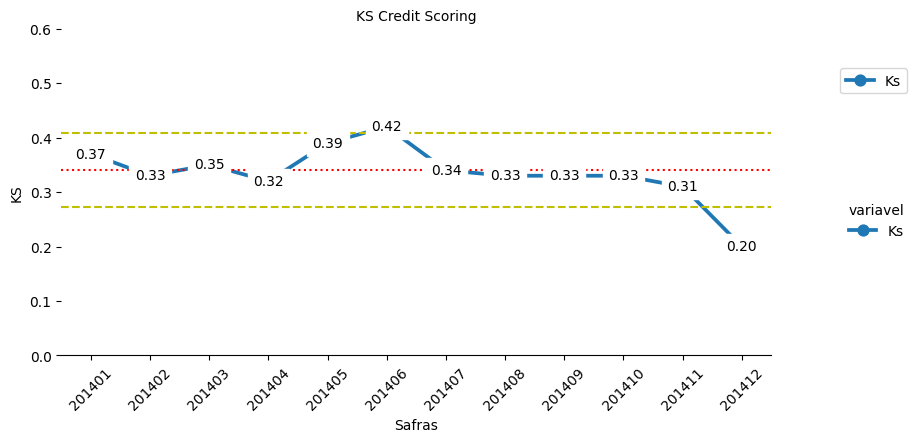

In [95]:
mdl = LGBMClassifier(verbosity=-1, extra_tree=True, random_state=2024)

features_filter = df_final_metric.iloc[0,0]

df_full = trainer_mdl(features_filter, mdl)
df_ks = calculate_ks_safra(df_full)
        
graph_ks(df_ks)

In [96]:
# Obter todos os hiperparâmetros
hiperparametros = mdl.get_params()

print("Hiperparâmetros do modelo:")
known_good_params={}
for param in ['learning_rate', 'num_leaves', 'subsample', 'colsample_bytree', 'n_estimators', 'min_child_weight', 'reg_alpha', 'reg_lambda', 'extra_tree']:
    known_good_params[param]= hiperparametros[param]
    
print(known_good_params)

Hiperparâmetros do modelo:
{'learning_rate': 0.1, 'num_leaves': 31, 'subsample': 1.0, 'colsample_bytree': 1.0, 'n_estimators': 100, 'min_child_weight': 0.001, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'extra_tree': True}


0
0.34 0.33 0.01


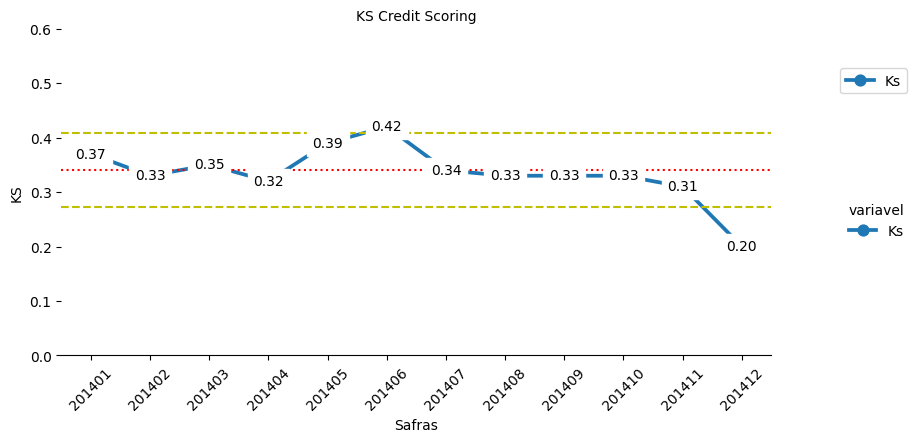

1
0.32 0.26 0.06


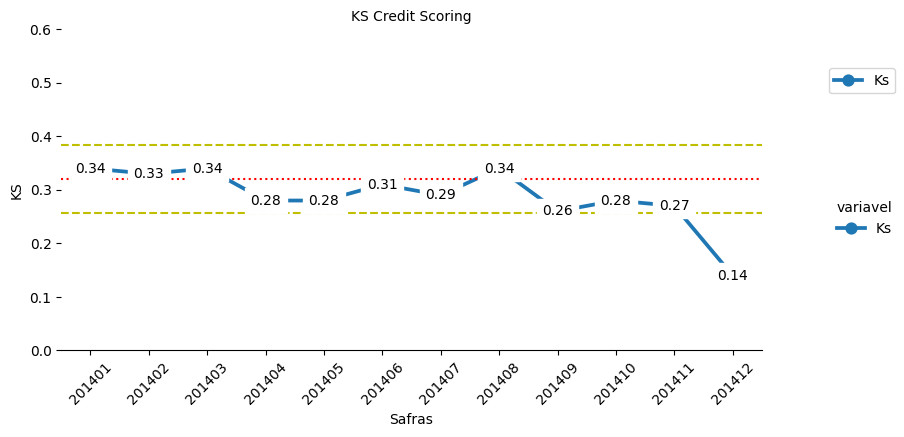

2
0.32 0.28 0.04


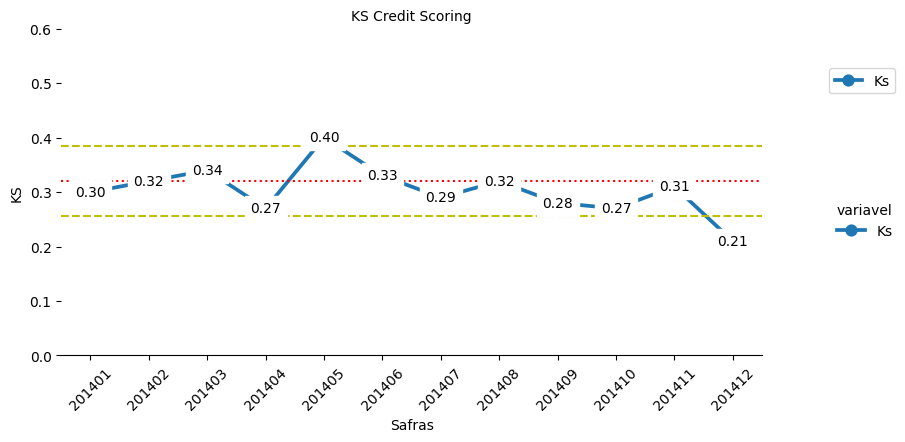

3
0.36 0.34 0.02


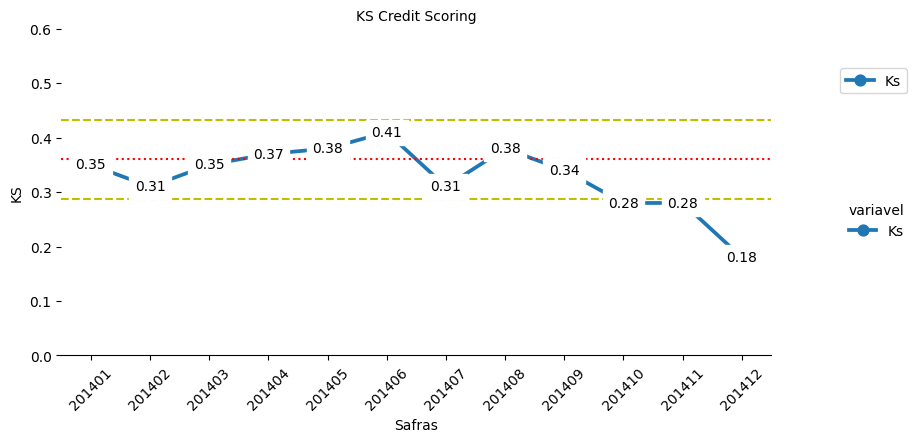

4
0.33 0.29 0.04


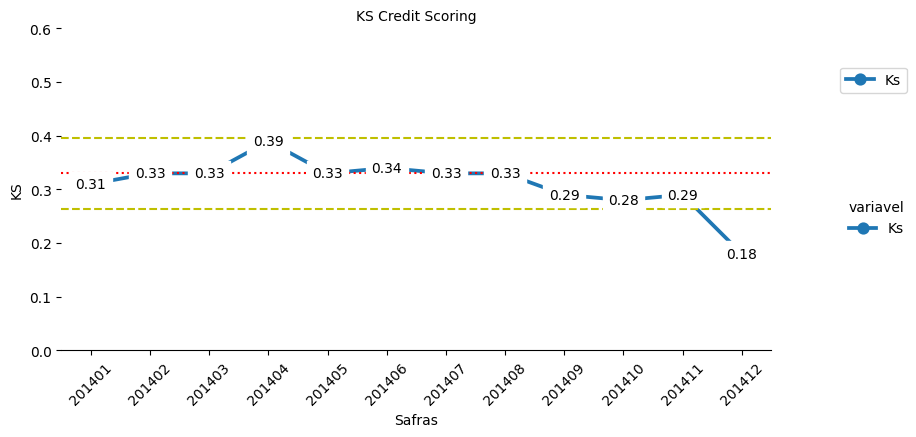

5
0.33 0.29 0.04


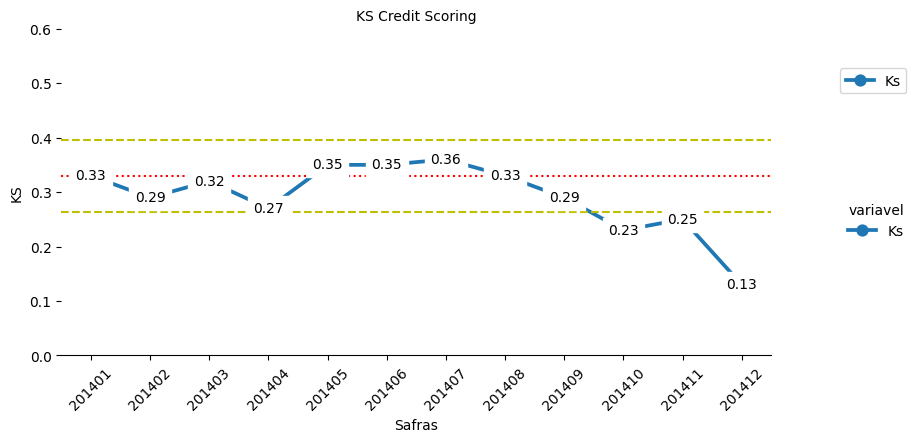

6
0.36 0.31 0.05


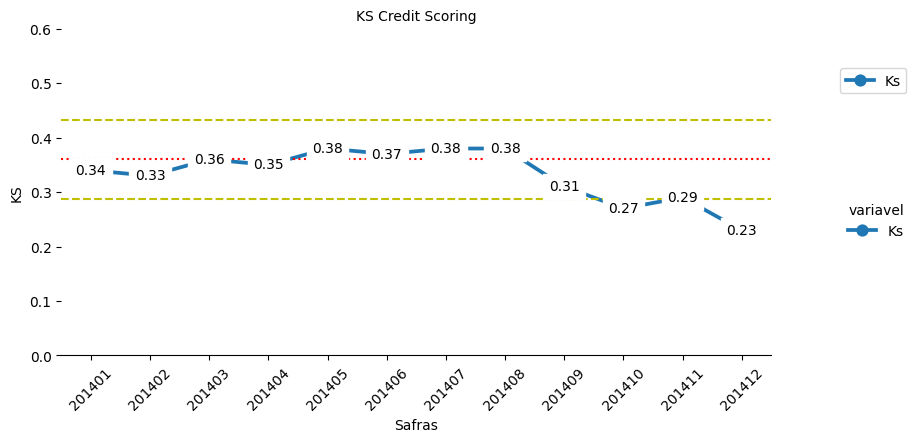

7
0.4 0.33 0.07


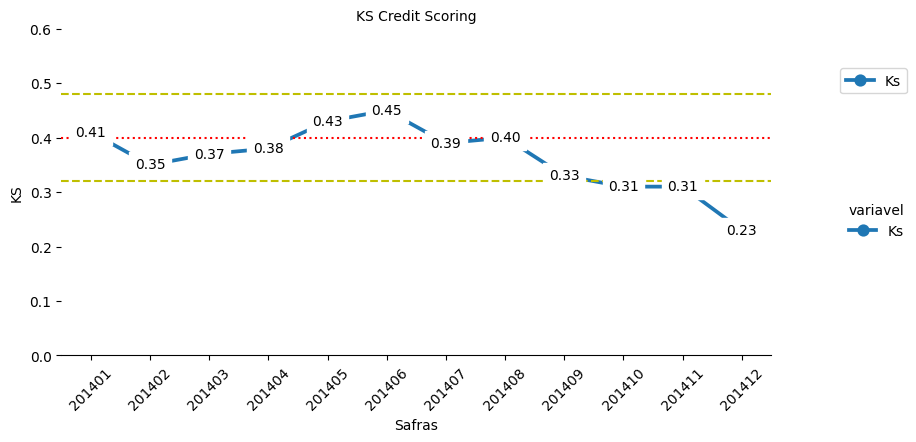

8
0.34 0.26 0.08


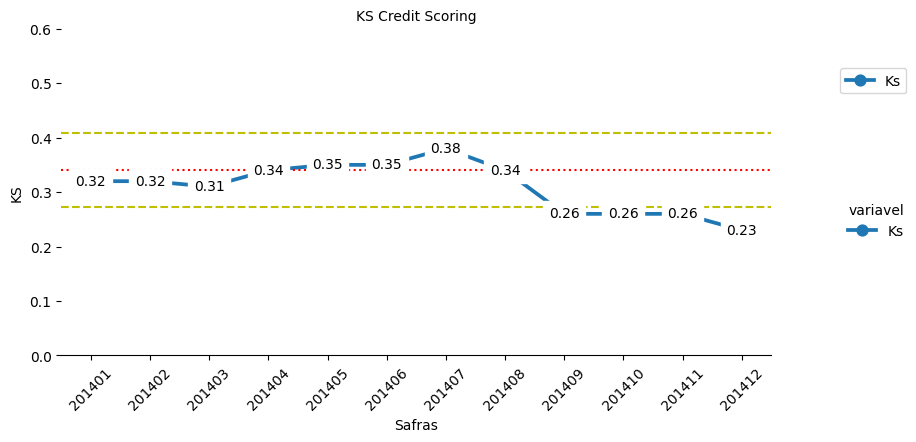

9
0.35 0.27 0.08


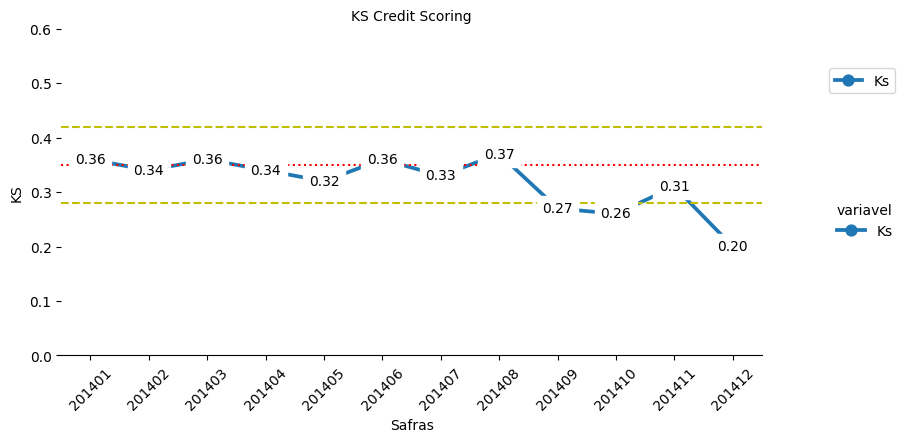

10
0.29 0.21 0.08


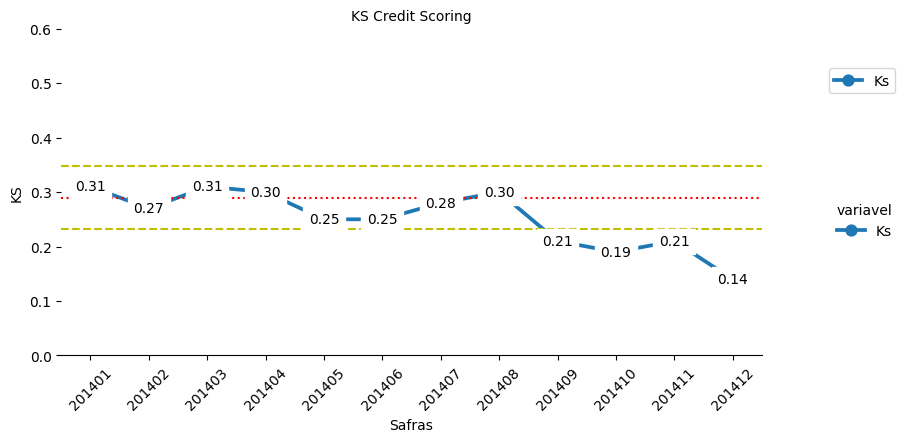

11
0.38 0.32 0.06


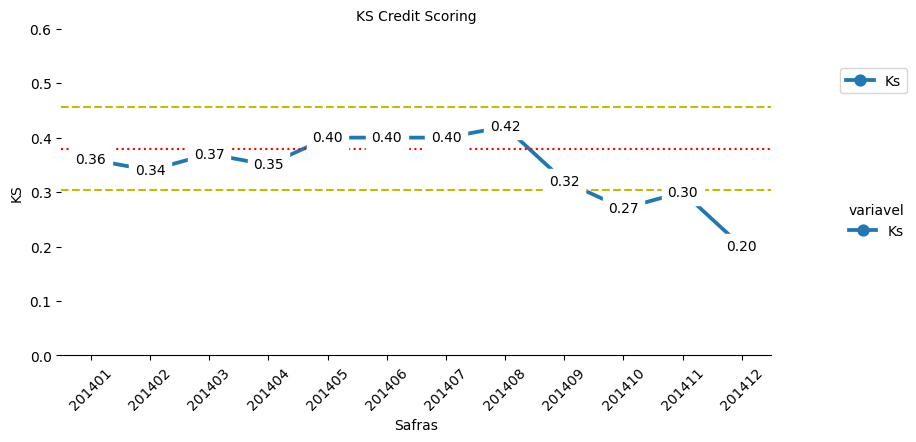

12
0.36 0.27 0.09


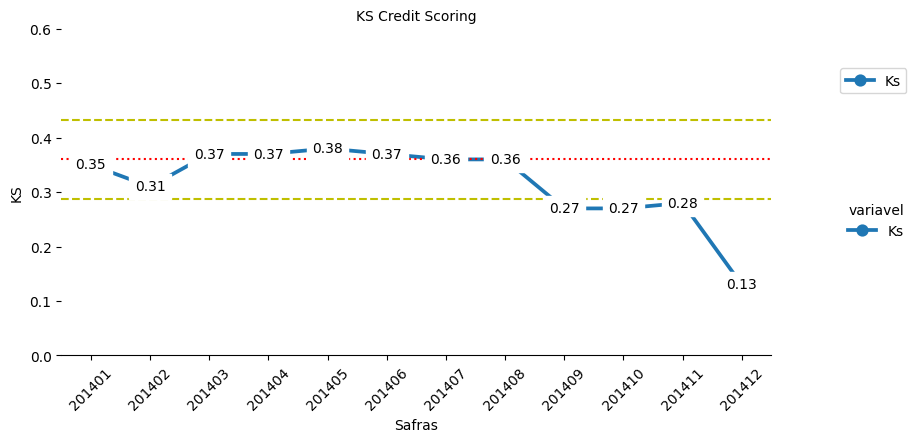

13
0.4 0.37 0.03


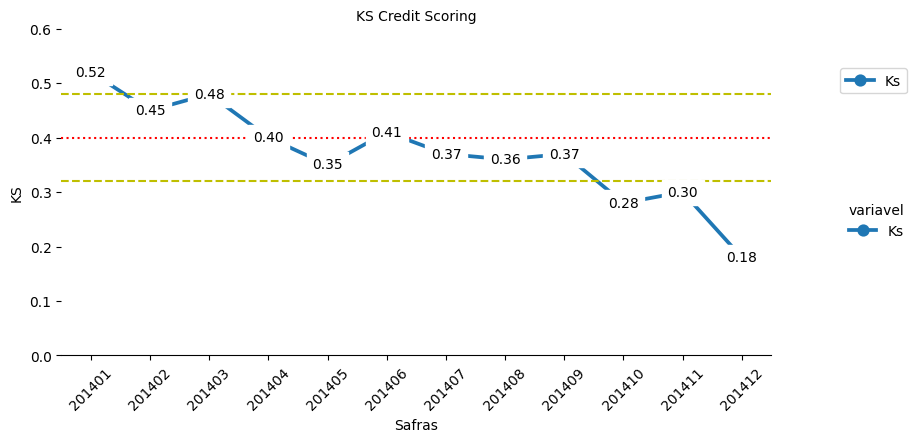

14
0.42 0.35 0.07


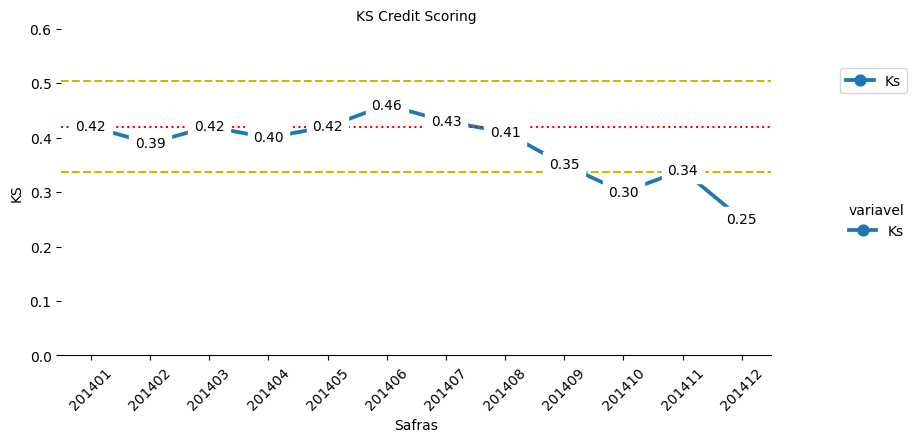

15
0.32 0.25 0.07


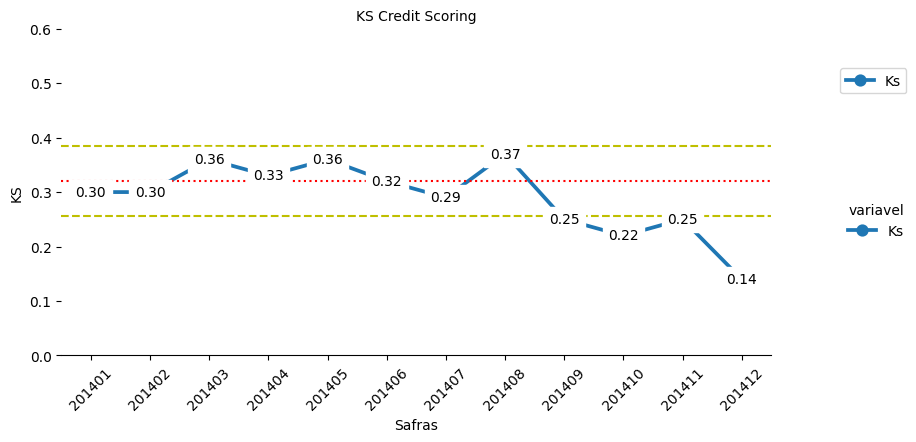

16
0.3 0.21 0.09


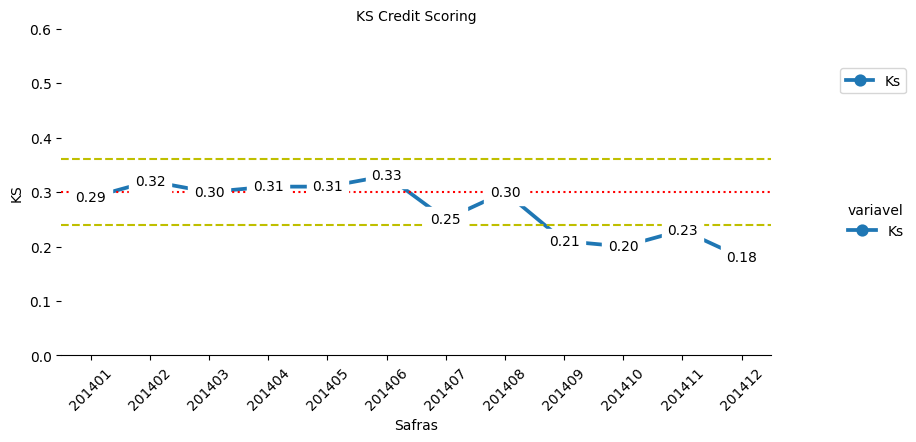

17
0.41 0.31 0.1


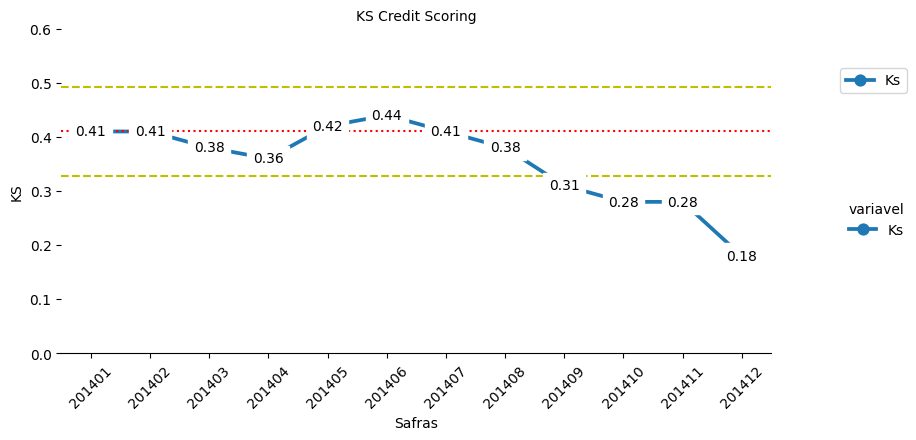

18
0.41 0.31 0.1


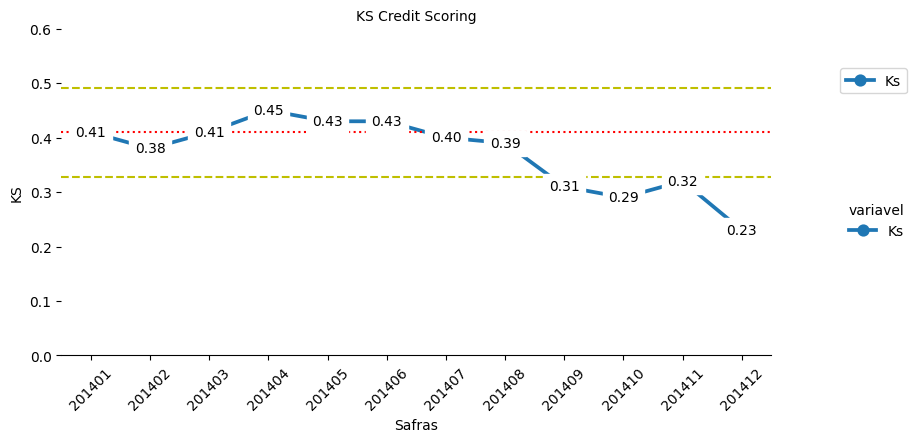

19
0.43 0.33 0.1


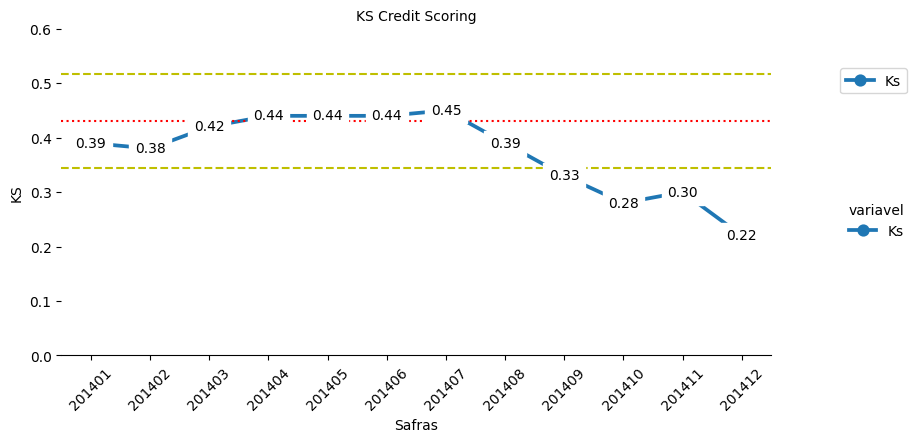

In [87]:
list_new = []


for ind, features_filter in enumerate(df_final_metric[0:20]['features'].values):
    print(ind)
    mdl = LGBMClassifier(verbosity=-1, extra_tree=True, random_state=2024)
    
    df_full = trainer_mdl(features_filter, mdl)
    df_ks = calculate_ks_safra(df_full)
        
    graph_ks(df_ks)

In [97]:
print(df_final_metric['features'].values[0])

['VAR_57', 'VAR_64', 'VAR_9', 'VAR_25', 'VAR_20', 'VAR_10_is_null', 'VAR_16_is_null', 'VAR_32']


## 5 - Tuning Hiperparâmetros

In [98]:
# Lista de features
features_list = df_final_metric['features'].values[0]

# Preparar dados de treino e validação
X_train = df_train[features_list+['safra']]
y_train = df_train[['y','safra']]

X_val = df_validation[features_list+['safra']]
y_val = df_validation[['y','safra']]

# Configurar splits por safra para validação
val_safras = df_validation['safra'].unique()
train_safras = df_train['safra'].unique()

# Espaço de busca de hiperparâmetros para LightGBM
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 100),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'extra_tree': hp.choice('extra_tree', [True, False])  
}


def calculate_ks(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    return np.max(np.abs(tpr - fpr))

def objective(params):
    # Converter para tipos corretos
    params = {
        'learning_rate': params['learning_rate'],
        'num_leaves': int(params['num_leaves']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'n_estimators': int(params['n_estimators']),
        'min_child_weight': params['min_child_weight'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda']
    }
    
    model = LGBMClassifier(**params, random_state=42, verbose=-1)
    
    # Treinar com dados de treino
    model.fit(X_train.drop(columns=['safra']), y_train.drop(columns=['safra']))
    
    # Prever para cada safra de validação
    safra_aucs = []
    safra_ks=[]
    for safra_idx in list(train_safras)+list(val_safras):
        X_safra = pd.concat([X_train, X_val],axis=0)
        y_safra = pd.concat([y_train, y_val], axis=0)
        
        X_safra = X_safra[X_safra['safra'] == safra_idx]
        y_safra = y_safra[y_safra['safra'] == safra_idx]
        
        preds = model.predict_proba(X_safra.drop(columns=['safra']))[:, 1]
        auc_var = roc_auc_score(y_safra.drop(columns=['safra']), preds)
        safra_aucs.append(auc_var)
        
        ks = calculate_ks(y_safra.drop(columns=['safra']), preds)
        safra_ks.append(ks)
        
    
    # Calcular média e desvio padrão
    mean_auc = np.mean(safra_aucs)
    std_auc = np.std(safra_aucs)
    
    mean_ks = np.mean(safra_ks)
    std_ks = np.std(safra_ks)
    
    # Penalizar alta variância
    # score = mean_auc - 0.7*std_auc
    score = 0.3*mean_ks - 0.7*std_ks
    
    return {'loss': -score, 'status': STATUS_OK, 'mean_auc': mean_auc, 'std_auc': std_auc, 'mean_ks': mean_auc, 'std_ks': std_auc,}

# Executar otimização
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials,
            points_to_evaluate=[known_good_params])  # Seed inicial

# Melhores parâmetros
print("Melhores parâmetros encontrados:")
print(best)


100%|██████████| 200/200 [18:33<00:00,  5.57s/trial, best loss: -0.09604995466043029]
Melhores parâmetros encontrados:
{'colsample_bytree': np.float64(0.7514123847793694), 'extra_tree': np.int64(1), 'learning_rate': np.float64(0.015578934312237492), 'min_child_weight': np.float64(5.687814364145499), 'n_estimators': np.float64(200.0), 'num_leaves': np.float64(42.0), 'reg_alpha': np.float64(0.49886609739738613), 'reg_lambda': np.float64(0.6733439230347765), 'subsample': np.float64(0.7788639554398702)}


In [99]:

# Treinar modelo final com melhores parâmetros
best_params = {
    'learning_rate': best['learning_rate'],
    'num_leaves': int(best['num_leaves']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'min_child_weight': best['min_child_weight'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda']
}

final_model = LGBMClassifier(**best_params, random_state=42, verbose=-1)
final_model.fit(X_train.drop(columns=['safra']), y_train.drop(columns=['safra']))

# Avaliação nas safras de validação
print("\nDesempenho por safra (validação):")
for safra in df_validation['safra'].unique():
    safra_data = df_validation[df_validation['safra'] == safra]
    X_safra = safra_data[features_list]
    y_safra = safra_data['y']
    preds = final_model.predict_proba(X_safra)[:, 1]
    auc_var = roc_auc_score(y_safra, preds)
    print(f"Safra {safra}: AUC = {auc_var:.4f}")

# Avaliação no out-of-time
print("\nDesempenho no out-of-time:")
for safra in df_out['safra'].unique():
    safra_data = df_out[df_out['safra'] == safra]
    X_safra = safra_data[features_list]
    y_safra = safra_data['y']
    preds = final_model.predict_proba(X_safra)[:, 1]
    auc_var = roc_auc_score(y_safra, preds)
    print(f"Safra {safra}: AUC = {auc_var:.4f}")


Desempenho por safra (validação):
Safra 201409: AUC = 0.7212
Safra 201410: AUC = 0.6933

Desempenho no out-of-time:
Safra 201412: AUC = 0.6549
Safra 201411: AUC = 0.7222


0.36 0.33 0.03


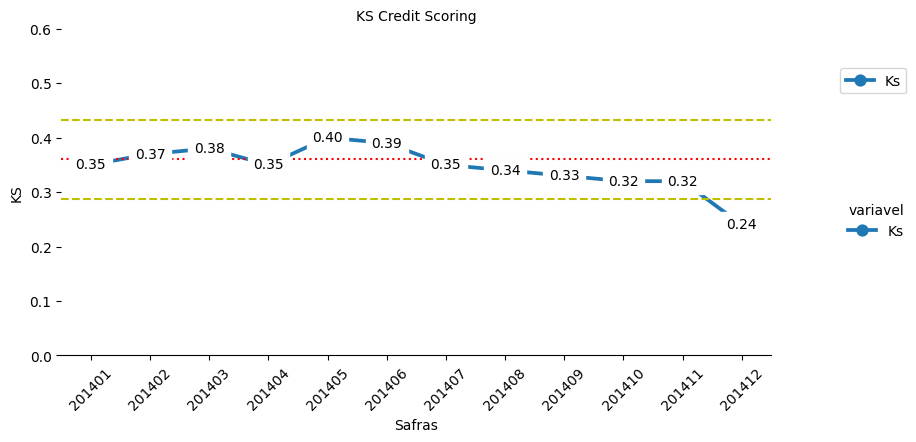


Resumo do desempenho:
KS Médio Treino: 0.36
KS Médio Validação: 0.33
KS Médio Out-of-time: 0.28


In [101]:
def calculate_ks_safra(df_full):
    list_dates = []
    list_ks = []
    list_auc_scores = []  # Mudei o nome da variável
    
    for date in sorted(df_full['safra'].unique()):
        list_dates.append(date)
        df_tmp = df_full[df_full['safra'] == date]
        
        # Calcula KS
        ks = calculate_metrics(df_tmp, 'y', "bin")
        list_ks.append(ks)
        
        # Calcula AUC usando roc_auc_score diretamente
        auc_score = roc_auc_score(df_tmp['y'], df_tmp['predict_proba'])
        list_auc_scores.append(np.round(auc_score, 2))
    
    return pd.DataFrame({'safra': list_dates, 'ks': list_ks, 'auc': list_auc_scores})


# Após treinar o modelo final:
features_list = df_final_metric['features'].values[0]
target = 'y'

# Usar a função trainer_mdl com o modelo treinado
df_full = trainer_mdl(features_list, final_model)

# Calcular métricas por safra
df_ks = calculate_ks_safra(df_full)

# Plotar gráficos
graph_ks(df_ks)

# Avaliação adicional
print("\nResumo do desempenho:")
print(f"KS Médio Treino: {df_ks[df_ks['safra'] <= 201408]['ks'].median():.2f}")
print(f"KS Médio Validação: {df_ks[df_ks['safra'].isin([201409, 201410])]['ks'].median():.2f}")
print(f"KS Médio Out-of-time: {df_ks[df_ks['safra'] > 201410]['ks'].median():.2f}")

## 6 - Reduzindo Complexidade Modelo

In [102]:
mdl = LGBMClassifier(**best_params, random_state=42, verbose=-1)

X_train = df_train[features_list]
y_train = df_train[[target]]

X_val = df_validation[features_list]
y_val = df_validation[[target]]

mdl.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=np.float64(0.7514123847793694),
               learning_rate=np.float64(0.015578934312237492),
               min_child_weight=np.float64(5.687814364145499), n_estimators=200,
               num_leaves=42, random_state=42,
               reg_alpha=np.float64(0.49886609739738613),
               reg_lambda=np.float64(0.6733439230347765),
               subsample=np.float64(0.7788639554398702), verbose=-1)

In [103]:
# %%time 
shap_values = shap.TreeExplainer(mdl).shap_values(X_val)

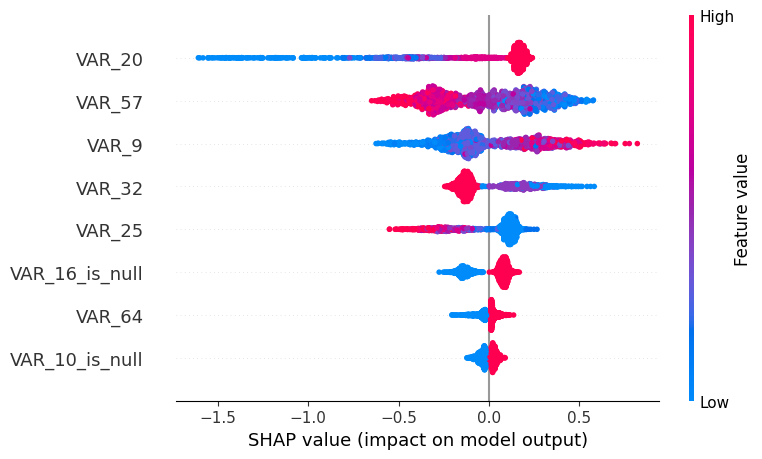

In [104]:
shap.summary_plot(shap_values, X_val, max_display = 100)

In [105]:
vals = np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(features_filter, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=True, inplace=True)
feature_importance['col_name'].values

array(['VAR_10_is_null', 'VAR_64', 'VAR_16_is_null', 'VAR_25', 'VAR_32',
       'VAR_9', 'VAR_57', 'VAR_20'], dtype=object)

In [106]:
def calculate_validation_new(X, y, X_val, y_val, mdl, list_features):
    ks = run_validation_ks(X, y, mdl, list_features)
    
    mdl.fit(X[list_features], y)
    
    X['predict_proba'] = mdl.predict_proba(X[list_features])[:, 1]
    X[target] = y[target].values
        
    X_val['predict_proba'] = mdl.predict_proba(X_val[list_features])[:, 1]
    X_val[target] = y_val[target].values
    
    optb = generate_bins(X, 'predict_proba', target)
    
    X_val['bins_new'] = optb.transform(X_val['predict_proba'].values, metric="indices")
         
    print(X_val['bins_new'].max())
    
    ks_val = calculate_metrics(X_val, target, "bins_new")
    
    fpr, tpr, _ = roc_curve(y, X['predict_proba'])

    roc_auc_dev = auc(fpr, tpr)
    
    fpr, tpr, _ = roc_curve(y_val, X_val['predict_proba'])
    roc_auc_val = auc(fpr, tpr)
    
    print(f"KS Cross-Validation: {ks}")
    print(f"KS Validation: {ks_val}")
    print(f"ROC AUC Dev: {np.round(roc_auc_dev, 2)}")
    print(f"ROC AUC Val: {np.round(roc_auc_val,2)}")
    
    return ks, ks_val, roc_auc_dev, roc_auc_val

In [107]:
ks_val_ori = np.round(df_ks[df_ks['safra'].isin([201409, 201410])]['ks'].median(),2)
ks_val_ori

np.float64(0.32)

In [108]:
%%time

mdl = LGBMClassifier(**best_params, random_state=42, verbose=-1)
    
features_filter = feature_importance['col_name'].values

features = feature_importance['col_name'].values

list_remove = []
for ind, col in enumerate(features):
    print(f"========== {ind+1}/{len(features)} ==========")
    features_select = list(set(features_filter) - set(list_remove))
    features_select = list(set(features_select) - set([col]))
    
    X_val = df_validation[features_select]
    y_val = df_validation[[target]]

    X = df_train[features_select]
    y = df_train[[target]]
    
    print(col)
    ks, ks_val, roc_auc_dev, roc_auc_val = calculate_validation_new(X, y, X_val, y_val, mdl, features_select)
    
    if (ks_val > ks_val_ori):
        list_remove.append(col)
        # ks_val_ori = ks_val
        
        mdl = LGBMClassifier(**best_params, random_state=42, verbose=-1)

        df_full = trainer_mdl(features_select, mdl)
        df_ks = calculate_ks_safra(df_full)
        
        graph_ks(df_ks)
    
    print(list_remove)    
    print('=============================')

========== 1/8 ==========
VAR_10_is_null
4
KS Cross-Validation: 0.26
KS Validation: 0.28
ROC AUC Dev: 0.76
ROC AUC Val: 0.71
[]
========== 2/8 ==========
VAR_64
4
KS Cross-Validation: 0.25
KS Validation: 0.28
ROC AUC Dev: 0.76
ROC AUC Val: 0.71
[]
========== 3/8 ==========
VAR_16_is_null
4
KS Cross-Validation: 0.24
KS Validation: 0.26
ROC AUC Dev: 0.76
ROC AUC Val: 0.7
[]
========== 4/8 ==========
VAR_25
4
KS Cross-Validation: 0.24
KS Validation: 0.3
ROC AUC Dev: 0.75
ROC AUC Val: 0.71
[]
========== 5/8 ==========
VAR_32
4
KS Cross-Validation: 0.26
KS Validation: 0.27
ROC AUC Dev: 0.75
ROC AUC Val: 0.7
[]
========== 6/8 ==========
VAR_9
4
KS Cross-Validation: 0.23
KS Validation: 0.27
ROC AUC Dev: 0.72
ROC AUC Val: 0.7
[]
========== 7/8 ==========
VAR_57
4
KS Cross-Validation: 0.23
KS Validation: 0.27
ROC AUC Dev: 0.72
ROC AUC Val: 0.69
[]
========== 8/8 ==========
VAR_20
4
KS Cross-Validation: 0.24
KS Validation: 0.24
ROC AUC Dev: 0.75
ROC AUC Val: 0.68
[]
CPU times: user 21.8 s, sys: 

In [109]:
df_ks

,safra,ks,auc
0,201401,0.35,0.75
1,201402,0.37,0.76
2,201403,0.38,0.76
3,201404,0.35,0.76
4,201405,0.40,0.77
5,201406,0.39,0.77
6,201407,0.35,0.75
7,201408,0.34,0.76
8,201409,0.33,0.72
9,201410,0.32,0.69


In [110]:
print(list(set(features_filter)-set(list_remove)))

['VAR_64', 'VAR_20', 'VAR_9', 'VAR_57', 'VAR_10_is_null', 'VAR_16_is_null', 'VAR_32', 'VAR_25']


## 7 - Interpretando Modelo

In [111]:
mdl = LGBMClassifier(**best_params, random_state=42, verbose=-1)
    
features_filter = list(set(features_filter)-set(list_remove))

X_train = df_train[features_filter]
y_train = df_train[[target]]

X_val = df_validation[features_filter]
y_val = df_validation[[target]]

# Treinando com Treino + Validação
mdl.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

LGBMClassifier(colsample_bytree=np.float64(0.7514123847793694),
               learning_rate=np.float64(0.015578934312237492),
               min_child_weight=np.float64(5.687814364145499), n_estimators=200,
               num_leaves=42, random_state=42,
               reg_alpha=np.float64(0.49886609739738613),
               reg_lambda=np.float64(0.6733439230347765),
               subsample=np.float64(0.7788639554398702), verbose=-1)

In [112]:
# %%time 
shap_values = shap.TreeExplainer(mdl).shap_values(X_val)

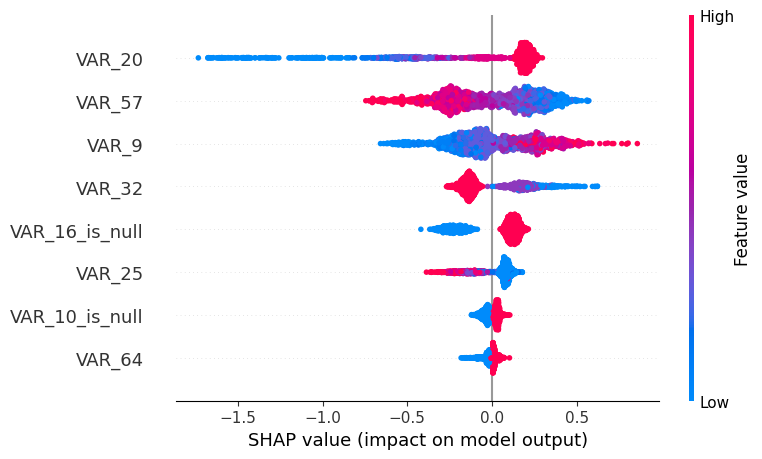

In [113]:
shap.summary_plot(shap_values, X_val, max_display = 100)

In [114]:
vals = np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(features_filter, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=True, inplace=True)
feature_importance['col_name'].values

array(['VAR_64', 'VAR_10_is_null', 'VAR_25', 'VAR_16_is_null', 'VAR_32',
       'VAR_9', 'VAR_57', 'VAR_20'], dtype=object)

## 8 - Modelo Final + Calibração

In [115]:
def generate_bins_new(df, feature, target):
    optb = OptimalBinning(
        name=feature,
        min_event_rate_diff=0.001,
        dtype="numerical",
        solver="cp",
        min_n_bins=2,
        max_pvalue=0.05,
        max_n_bins=5, # default 20
        min_prebin_size=0.05, #0.01,
        special_codes=[-1],
        monotonic_trend="auto_asc_desc")
    
    optb.fit(df[feature].values, df[target].values)
    
    return optb
    #return optb.transform(df[feature].values, metric="indices")

In [116]:
mdl = LGBMClassifier(**best_params, random_state=42, verbose=-1)

X_train = df_train[features_filter]
y_train = df_train[[target]]

X_val = df_validation[features_filter]
y_val = df_validation[[target]]

X_out = df_out[features_filter]
y_out = df_out[[target]]

# Treinando com Treino + Validação
mdl.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

df_train['predict_proba'] = mdl.predict_proba(X_train)[:, 1]
optb_new = generate_bins_new(df_train, 'predict_proba', target)
train = df_train[['id',	target, 'safra', 'predict_proba']]

df_validation['predict_proba'] = mdl.predict_proba(X_val)[:, 1]
validation = df_validation[['id', target, 'safra', 'predict_proba']]

df_out['predict_proba'] = mdl.predict_proba(X_out)[:, 1]
out = df_out[['id', target, 'safra', 'predict_proba']]

df_full = pd.concat([train, validation, out])
df_full['bins_new'] = optb_new.transform(df_full['predict_proba'].values, metric="indices")
#df_full['bins_ori'] = optb_ori.transform(df_full['prob_evento'].values, metric="indices")

df_full.rename(columns={'bins_new': 'bin'}, inplace=True)
df_full.head()

,id,y,safra,predict_proba,bin
0,1,0,201404,0.100468,1
1,2,0,201407,0.133744,1
2,3,0,201405,0.327221,3
3,5,1,201403,0.604421,4
4,6,0,201405,0.330365,3


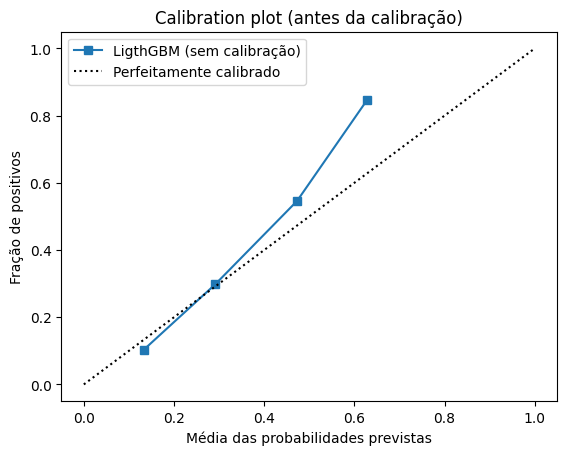

In [117]:
from sklearn.calibration import calibration_curve,CalibratedClassifierCV

fracao_positivos, media_prob_previstas = calibration_curve(df_full[target], df_full['predict_proba'], n_bins=5)

plt.plot(media_prob_previstas, fracao_positivos, "s-", label="LigthGBM (sem calibração)")
plt.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")  
plt.xlabel("Média das probabilidades previstas")
plt.ylabel("Fração de positivos")
plt.title('Calibration plot (antes da calibração)')
plt.legend()
plt.show()

In [118]:
calibrated_cat_sigmoid = CalibratedClassifierCV(mdl, method='isotonic', cv='prefit') 
calibrated_cat_sigmoid.fit(pd.concat([X_train, X_val, X_out]), df_full[target])

# Prevendo probabilidades no conjunto de teste após a calibração
y_prob_sigmoid = calibrated_cat_sigmoid.predict_proba(pd.concat([X_train, X_val, X_out]))[:, 1]

In [119]:
df_full['predict_proba_calib'] = y_prob_sigmoid

In [120]:
import joblib

filename = f'models/model_calib.pkl'
joblib.dump(calibrated_cat_sigmoid, filename)

['models/model_calib.pkl']

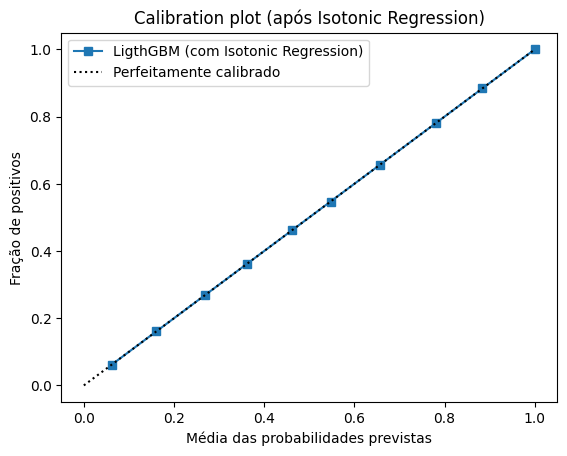

In [143]:
# Calculando o calibration curve
fracao_positivos_sigmoid, media_prob_previstas_sigmoid = calibration_curve(df_full[target], y_prob_sigmoid, n_bins=10)

# Plotando o Calibration Plot após a calibração
plt.plot(media_prob_previstas_sigmoid, fracao_positivos_sigmoid, "s-", label="LigthGBM (com Isotonic Regression)")
plt.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")  # Linha de calibração perfeita
plt.xlabel("Média das probabilidades previstas")
plt.ylabel("Fração de positivos")
plt.title('Calibration plot (após Isotonic Regression)')
plt.legend()
plt.show()

In [122]:
import joblib

filename = f'models/model.pkl'
joblib.dump(mdl, filename)

['models/model.pkl']

In [123]:
df_full.to_csv('dados/df_final_gh_calibrado.csv', index=False)

## 9 - Avaliando Performance Final + GHs Iniciais

In [ ]:
df_train['predict_proba'] = calibrated_cat_sigmoid.predict_proba(X_train)[:, 1]
optb_new = generate_bins_new(df_train, 'predict_proba', target)
train = df_train[['id',	target, 'safra', 'predict_proba']]

df_validation['predict_proba'] = calibrated_cat_sigmoid.predict_proba(X_val)[:, 1]
validation = df_validation[['id', target, 'safra', 'predict_proba']]

df_out['predict_proba'] = calibrated_cat_sigmoid.predict_proba(X_out)[:, 1]
out = df_out[['id', target, 'safra', 'predict_proba']]

df_full = pd.concat([train, validation, out])
df_full['bins_new'] = optb_new.transform(df_full['predict_proba'].values, metric="indices")
#df_full['bins_ori'] = optb_ori.transform(df_full['prob_evento'].values, metric="indices")

df_full.rename(columns={'bins_new': 'bin'}, inplace=True)
df_full.head()

,id,y,safra,predict_proba,bin
0,1,0,201404,0.047782,0
1,2,0,201407,0.097054,1
2,3,0,201405,0.357771,3
3,5,1,201403,0.800000,4
4,6,0,201405,0.357771,3


### Distribuição GHs

In [125]:
def graph_distribution_bins(df, title):
    GROUP_QTD = df.groupby(['safra','bin']).size().unstack().sort_values(by='safra',ascending=True)
    
    ax = (GROUP_QTD.T*100.0/GROUP_QTD.T.sum()).T.plot(kind='bar',figsize=(25,10),width=0.5,stacked=True, rot=0)
    
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x ,y = p.get_xy()
        ax.annotate('{:.2f}%'.format(height), (x + width/2, y + height*0.2), ha='center')
    
    ax.set_xlabel('Safras', fontsize=16)
    ax.set_ylabel('Quantidade  por bin', fontsize=16)
    plt.legend(title='Faixas de Risco', loc='upper right', bbox_to_anchor=(1.1, 0.7), fontsize=12)
    plt.title(title, fontsize=18)
    plt.show()

In [144]:
font = {'family' : 'DeJavu Serif',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

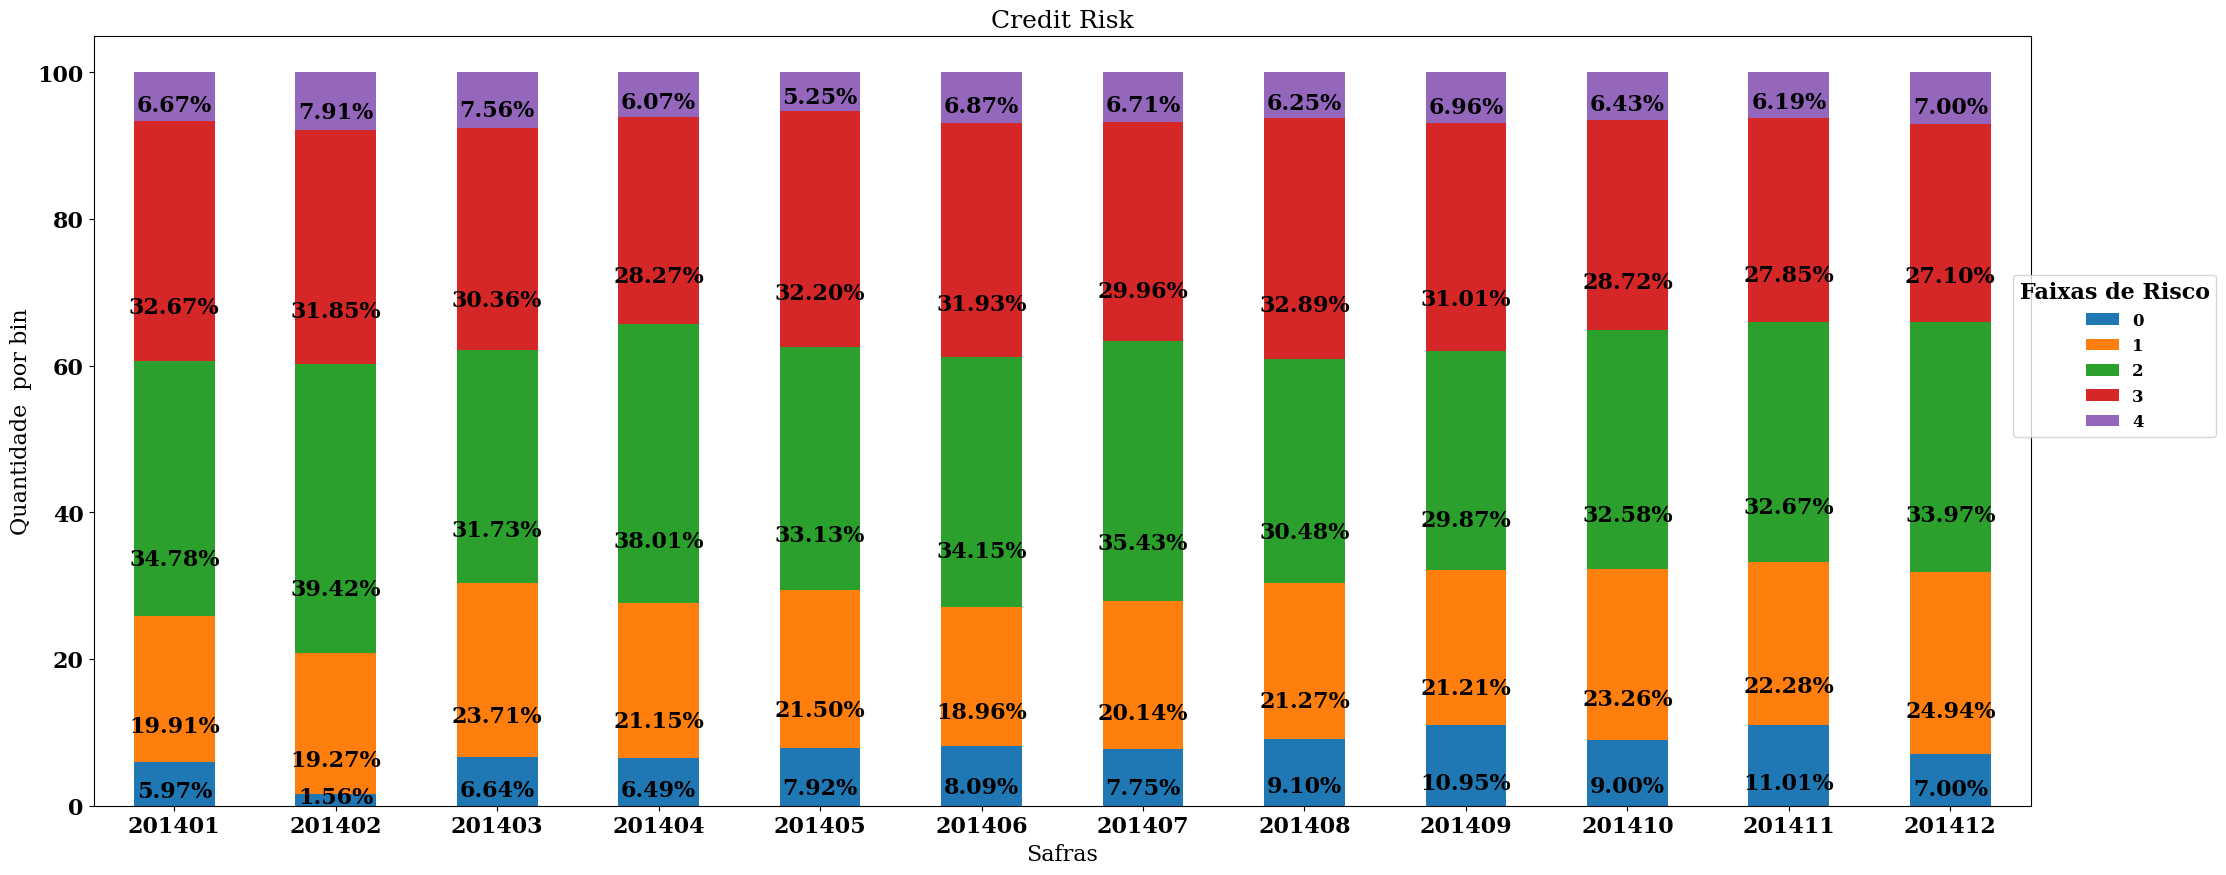

In [145]:
graph_distribution_bins(df_full, f"Credit Risk")

### KS

In [127]:
list_dates = []

list_ks = []
list_auc = []

list_ks_ori = []
list_auc_ori = []

for date in list(sorted(df_full['safra'].unique())):
    list_dates.append(date)
    
    df_tmp = df_full[df_full['safra']==date]
    
    ks = calculate_metrics(df_tmp, target, "bin")
    list_ks.append(ks)
        
    fpr, tpr, _ = roc_curve(df_tmp[target], df_tmp['predict_proba'])
    list_auc.append(np.round(auc(fpr, tpr), 2))
        
df_ks = pd.DataFrame({'safra':list_dates, 'ks':list_ks, 'auc': list_auc})

In [128]:
ks_dev = np.round(df_ks[(df_ks['safra']<=201408)][['ks', 'auc']].median()['ks'],2)
ks_dev

np.float64(0.36)

In [129]:
df_ks[df_ks['safra']>=201410][['ks', 'auc']].median()

ks     0.32
auc    0.73
dtype: float64

In [147]:
font = {'family' : 'DeJavu Serif',
        'weight' : 'bold',
        'size'   : 13}

plt.rc('font', **font)

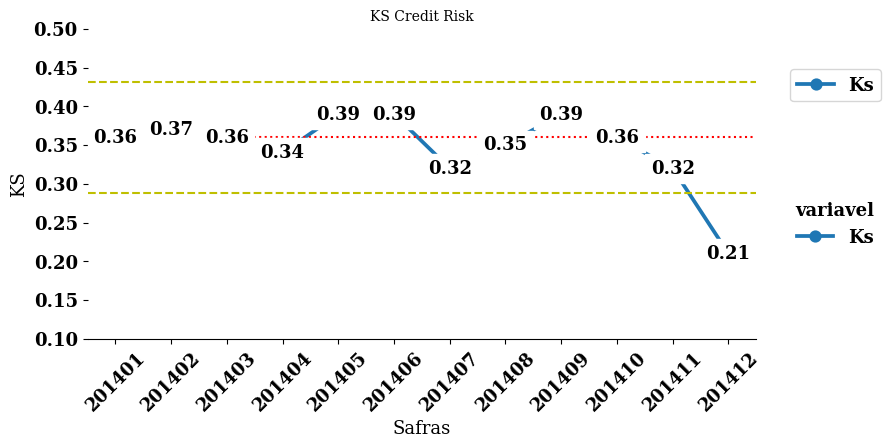

In [148]:
df_melted = pd.melt(df_ks, id_vars=['safra'], var_name='variavel', value_name='valor')
df_melted_ks = df_melted[df_melted['variavel'].isin(['ks'])]

legend_mapping = {'ks': 'Ks'}
df_melted_ks['variavel'] = df_melted_ks['variavel'].map(legend_mapping)

ax = sns.catplot(x="safra", y="valor", hue='variavel', height=4, aspect=2, capsize=.2, kind="point", data=df_melted_ks, palette = "tab10")

for ind_i, safra in enumerate(list(sorted(set(df_melted_ks['safra'].values)))):
    for var in list(sorted(set(df_melted_ks['variavel'].values))):
        value = df_melted_ks[(df_melted_ks['safra']==safra)&(df_melted_ks['variavel']==var)]['valor'].values[0]
        ax.ax.text(ind_i, value, f'{value:.2f}', backgroundcolor='white', color='black', ha='center', va='center', zorder=5)
        
ax.set(xlabel = 'Safras', ylabel = 'KS')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9))

plt.axhline(ks_dev*0.8,color='y', linestyle='dashed')
plt.axhline(ks_dev,color='r', linestyle='dotted')
plt.axhline(ks_dev*1.2,color='y', linestyle='dashed')

plt.title(f"KS Credit Risk", fontsize=10)
ax.despine(left=True)
plt.xticks(rotation=45)
plt.ylim(0.10, 0.5)
plt.show()

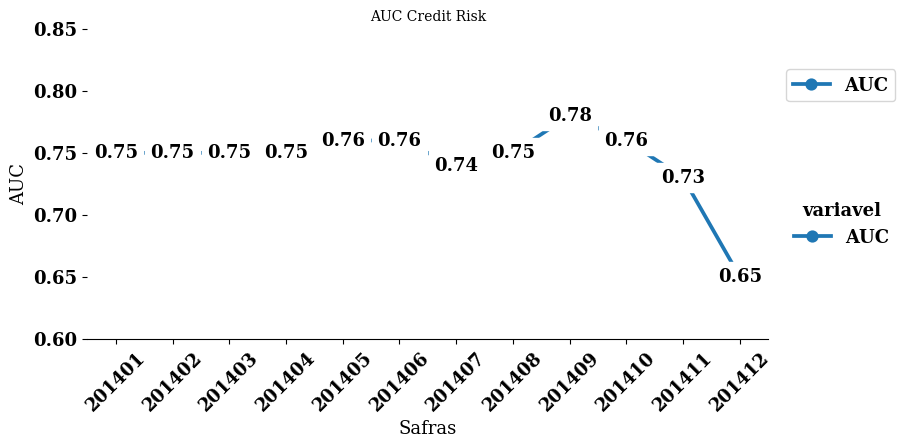

In [149]:
df_melted = pd.melt(df_ks, id_vars=['safra'], var_name='variavel', value_name='valor')
df_melted_auc = df_melted[df_melted['variavel'].isin(['auc'])]

legend_mapping = {'auc': 'AUC'}
df_melted_auc['variavel'] = df_melted_auc['variavel'].map(legend_mapping)

ax = sns.catplot(x="safra", y="valor", hue='variavel', height=4, aspect=2, capsize=.2, kind="point", data=df_melted_auc, palette = "tab10")

for ind_i, safra in enumerate(list(sorted(set(df_melted_auc['safra'].values)))):
    for var in list(sorted(set(df_melted_auc['variavel'].values))):
        value = df_melted_auc[(df_melted_auc['safra']==safra)&(df_melted_auc['variavel']==var)]['valor'].values[0]
        ax.ax.text(ind_i, value, f'{value:.2f}', backgroundcolor='white', color='black', ha='center', va='center', zorder=5)
        
ax.set(xlabel = 'Safras', ylabel = 'AUC')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9))

plt.title(f"AUC Credit Risk", fontsize=10)
ax.despine(left=True)
plt.xticks(rotation=45)
plt.ylim(0.60, 0.85)
plt.show()

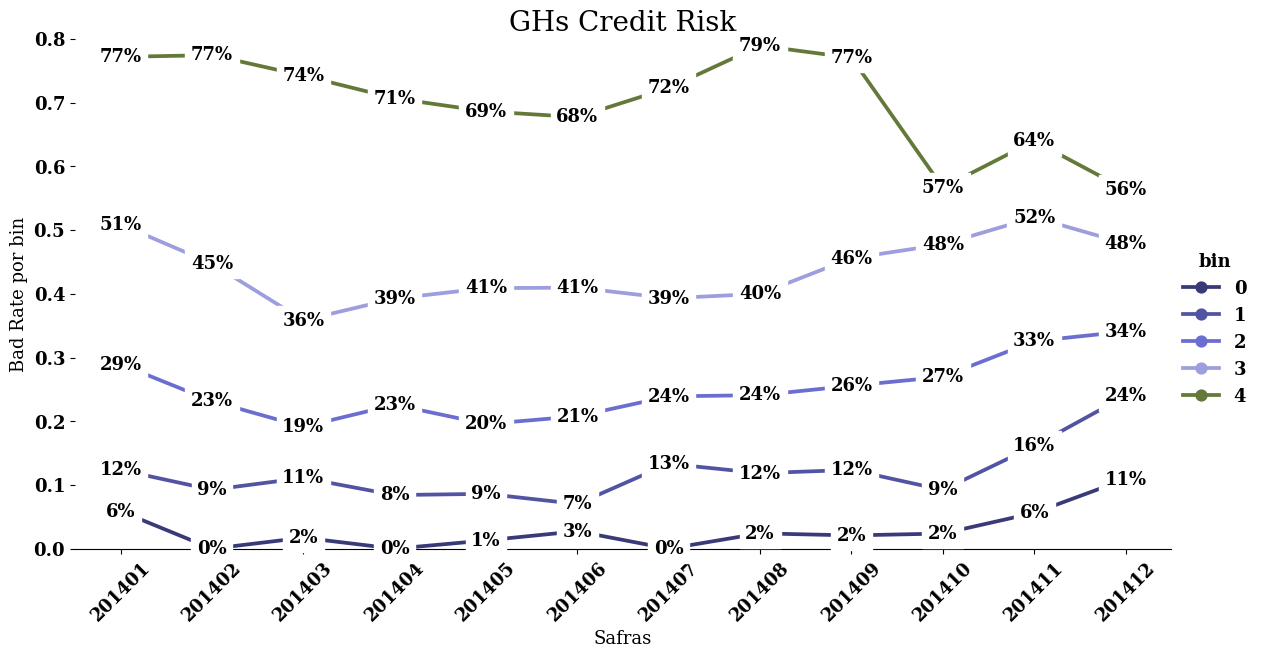

In [150]:
# Preparar os dados
bad_rate_ano_mes_collection = pd.DataFrame(
    df_full.groupby(['bin', 'safra'], as_index=False).apply(lambda x: x[target].sum()/len(x))
)
bad_rate_ano_mes_collection.columns = ['bin', 'safra', 'Bad_Rate']

# Criar o gráfico com mesma estrutura
ax = sns.catplot(
    x="safra", 
    y="Bad_Rate", 
    hue='bin', 
    height=6, 
    aspect=2,
    capsize=.2, 
    kind="point", 
    data=bad_rate_ano_mes_collection, 
    palette="tab20b"
)

# Adicionar os valores nos pontos igual ao exemplo
for ind_i, safra in enumerate(sorted(bad_rate_ano_mes_collection['safra'].unique())):
    for bin in sorted(bad_rate_ano_mes_collection['bin'].unique()):
        try:
            value = bad_rate_ano_mes_collection[
                (bad_rate_ano_mes_collection['safra'] == safra) & 
                (bad_rate_ano_mes_collection['bin'] == bin)
            ]['Bad_Rate'].values[0]
            
            ax.ax.text(
                ind_i,  # Usar índice da posição no eixo X
                value,
                f'{value:.0%}',  # Formato percentual com 2 decimais
                backgroundcolor='white',
                color='black',
                ha='center',
                va='center',
                zorder=5,
                fontsize=13
            )
        except IndexError:
            continue

# Configurações idênticas ao exemplo
ax.set(xlabel='Safras', ylabel='Bad Rate por bin')
# plt.legend(title='Faixas de Risco', loc='upper right', bbox_to_anchor=(1.2, 0.9))
plt.title("GHs Credit Risk", fontsize=20)
ax.despine(left=True)
plt.xticks(rotation=45)
plt.ylim(0, 0.8)  # Ajuste conforme sua escala
plt.show()

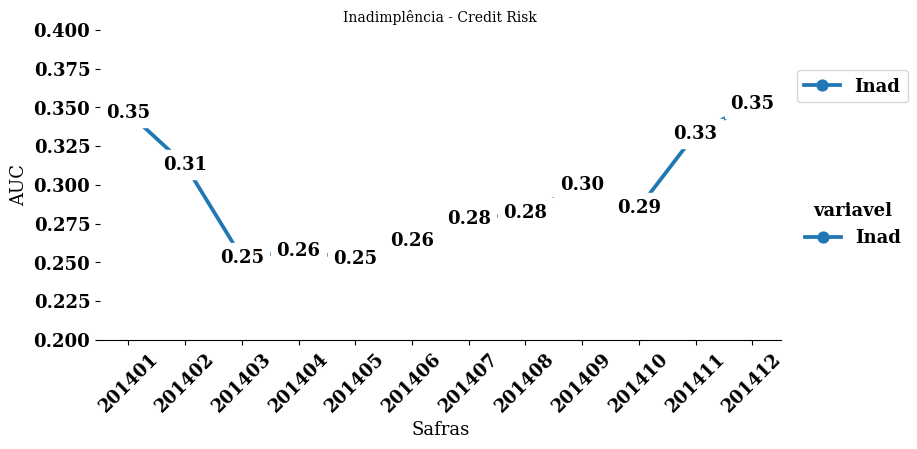

In [151]:
df_melted = pd.melt(df_full.groupby('safra',as_index=False)['y'].mean(), id_vars=['safra'], var_name='variavel', value_name='valor')
df_melted_auc = df_melted[df_melted['variavel'].isin(['y'])]

legend_mapping = {'y': 'Inad'}
df_melted_auc['variavel'] = df_melted_auc['variavel'].map(legend_mapping)

ax = sns.catplot(x="safra", y="valor", hue='variavel', height=4, aspect=2, capsize=.2, kind="point", data=df_melted_auc, palette = "tab10")

for ind_i, safra in enumerate(list(sorted(set(df_melted_auc['safra'].values)))):
    for var in list(sorted(set(df_melted_auc['variavel'].values))):
        value = df_melted_auc[(df_melted_auc['safra']==safra)&(df_melted_auc['variavel']==var)]['valor'].values[0]
        ax.ax.text(ind_i, value, f'{value:.2f}', backgroundcolor='white', color='black', ha='center', va='center', zorder=5)
        
ax.set(xlabel = 'Safras', ylabel = 'AUC')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.9))

plt.title(f"Inadimplência - Credit Risk", fontsize=10)
ax.despine(left=True)
plt.xticks(rotation=45)
plt.ylim(0.2, 0.4)
plt.show()